# INFOSYS 722 - BDAS ITERATION

# Predicting Crash Severity On New Zealand Roads

Ferdinand Djohar (adjo446)

## PREREQUISITES
Initialise and start spark session.

In [1]:
import datetime
start_time = datetime.datetime.now().replace(microsecond = 0)

import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bdas').getOrCreate()

## DATA UNDERSTANDING & DATA PREPARATION

### 2.2 Data Description
Data set consist of 104,032 records in total, sourced from three CSV files (i.e. one file for each year) with 38 attributes.

Documentation provided by NZTA tells us that most of the value types in the data set are categorical and numeric types. Some variables are derived from other variables e.g. **URBAN** variable is derived from **SPD_LIM** variable giving possible values of *'Urban'* where **SPD_LIM** is less than 80 or *'Open Road'* where **SPD_LIM** is greater or equal to 80.

Please refer to *Appendix A* in the report for more detailed list of attributes of the data set extracted from NZTA documentation.

In [2]:
df = spark.read.csv("Data/*.csv", header = True, inferSchema = True)

# Print out the dimension of the data frame
print(df.count()) #rows
print(len(df.columns)) #columns

104032
38


### 2.3 Data Exploration

View first few records of the data set.

In [3]:
df.limit(5).toPandas()

,CRASH_YEAR,CRASH_SEV,MULTI_VEH,HOLIDAY,LG_REGION_DESC,EASTING,NORTHING,CRASH_LOCN1,CRASH_LOCN2,OUTDTD_LOCN_DESC,...,ROAD_SURFACE,ROAD_WET,NUM_LANES,TRAFFIC_CTRL,SPD_LIM,URBAN,LIGHT,STREET_LIGHT,WEATHER_A,WEATHER_B
0,2017,F,Vehicle(s)+Pedestrian(s),Christmas/New Year,Northland,1688160,6101368,KERIKERI INLET ROAD,PA ROAD,Current location,...,Sealed,Dry,2,N/A,80,Openroad,Dark,On,Fine,Unknown
1,2017,F,Vehicle(s)+Pedestrian(s),Christmas/New Year,Northland,1642352,6126632,ORURU ROAD,RYDER ROAD,Current location,...,Sealed,Dry,2,N/A,100,Openroad,Dark,None,Fine,Unknown
2,2017,F,Multi vehicle,Christmas/New Year,Bay of Plenty,1942531,5794171,THORNTON ROAD,POWDRELL ROAD,Current location,...,Sealed,Dry,2,N/A,100,Openroad,Overcast,None,Fine,Unknown
3,2017,F,Multi vehicle,None,Canterbury,1564498,5161943,SH 75,RIFLE RANGE CV,Current location,...,Sealed,Wet,2,N/A,100,Openroad,Overcast,Unknown,Fine,Strong Wind
4,2017,F,Vehicle(s)+Pedestrian(s),None,Otago,1313029,4986865,SH 8,AIRPORT ROAD,Current location,...,Sealed,Dry,2,N/A,100,Openroad,Overcast,Unknown,Fine,Unknown


View schema of the data set.

In [4]:
df.printSchema()

root
 |-- CRASH_YEAR: integer (nullable = true)
 |-- CRASH_SEV: string (nullable = true)
 |-- MULTI_VEH: string (nullable = true)
 |-- HOLIDAY: string (nullable = true)
 |-- LG_REGION_DESC: string (nullable = true)
 |-- EASTING: integer (nullable = true)
 |-- NORTHING: integer (nullable = true)
 |-- CRASH_LOCN1: string (nullable = true)
 |-- CRASH_LOCN2: string (nullable = true)
 |-- OUTDTD_LOCN_DESC: string (nullable = true)
 |-- CRASH_RP_RS: integer (nullable = true)
 |-- INTERSECTION: string (nullable = true)
 |-- JUNCTION_TYPE: string (nullable = true)
 |-- CR_RD_SIDE_RD: integer (nullable = true)
 |-- CRASH_DIRN_DESC: string (nullable = true)
 |-- CRASH_DIST: integer (nullable = true)
 |-- CRASH_RP_DIRN_DESC: string (nullable = true)
 |-- DIRN_ROLE1_DESC: string (nullable = true)
 |-- CRASH_RP_DISP: integer (nullable = true)
 |-- CRASH_SH_DESC: string (nullable = true)
 |-- CRASH_RP_SH: string (nullable = true)
 |-- CRASH_RP_NEWS_DESC: string (nullable = true)
 |-- INTSN_MIDBLOCK:

### 2.4 Data Quality Verification
The data quality of the data set seems to be fairly high. Only three out of 38 variables have missing data (see the result of the code chunk below).

We also noticed that there are some variables have high proportion of *"Unknown"* and zero values which may result in such variables being identified as least important variables, thus excluded in later stages of our work.

Apart from minor data issues mentioned above, we found nothing of concern regarding the data quality of the data set.

In [5]:
import pandas as pd

from pyspark.sql.functions import isnan, when, count, col, regexp_replace

# Use spark to calculate the number of missing values for each column and convert the result to pandas.
# Note: the result will contain a single row with 38 columns, small enough to be handled by pandas in memory
missing_values = pd.concat(
    [
        df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose(),
        df.select([count(when(col(c) == " ", c)).alias(c) for c in df.columns]).toPandas().transpose()
    ],
    axis = 1
)

missing_values.columns = ["null", "whitespace"]

missing_values["total"] = df.count()
missing_values["missing"] = missing_values["null"] + missing_values["whitespace"]
missing_values["percent"] = missing_values["missing"] / missing_values["total"] * 100

In [6]:
# Show columns that have missing values
missing_values.loc[missing_values['percent'] > 0].sort_values("percent", ascending = False)

,null,whitespace,total,missing,percent
CRASH_DIRN_DESC,0,35316,104032,35316,33.947247
ROAD_LANE,0,54,104032,54,0.051907
CR_RD_SIDE_RD,1,0,104032,1,0.000961


### 3.1 Data Selection
A variable called **OUTDTD_LOCN_DESC** specifies whether a certain crash record has an outdated location or not. A crash is said to have an outdated location where the road might have moved or does not exist anymore. We decided to exclude outdated records from our data set because the data may no longer be valid.

In [7]:
# Exclude outdated data
crash_data = df.filter("OUTDTD_LOCN_DESC <> 'Outdated Location'")

print(crash_data.count())

104006


### 3.2 Data Cleansing
In section 2.4, we identified three variables with missing values. **CRASH_DIRN_DESC** and **ROAD_LANE** both have white spaces, while **CR_RD_SIDE_RD** has null values. We decided to impute white spaces with text constant *"Unknown"* and discard records with null values.

In [8]:
# Drop records with null values
crash_data = crash_data.na.drop()

# Impute white spaces with text constant "Unknown"
crash_data = crash_data.withColumn("ROAD_LANE", regexp_replace(crash_data["ROAD_LANE"], " ", "Unknown"))
crash_data = crash_data.withColumn("CRASH_DIRN_DESC", regexp_replace(crash_data["CRASH_DIRN_DESC"], " ", "Unknown"))

# Check the number of remaining rows
print(crash_data.count())

104005


In [9]:
crash_data.groupBy("ROAD_LANE").count().show()
crash_data.groupBy("CRASH_DIRN_DESC").count().show()

+---------+-----+
|ROAD_LANE|count|
+---------+-----+
|  Unknown|   54|
|        O|  674|
|        1|14251|
|        2|89026|
+---------+-----+

+---------------+-----+
|CRASH_DIRN_DESC|count|
+---------------+-----+
|        Unknown|35295|
|          South|20977|
|           East|13574|
|           West|13554|
|          North|20605|
+---------------+-----+



### 3.3 New Data Construction
In an attempt to reduce the granularity within our data set, we decided to reclassify two variables (**LIGHT** and **CRASH_SEV**) into two new variables (**DARK_LIGHT** and **FATAL_OR_SERIOUS**).

**DARK_LIGHT** is a categorical variable derived from **LIGHT** which tells us how much natural light was around the environment when the crash happened. Possible values of *Light*, *Dark* or *Unknown*.

**FATAL_OR_SERIOUS** is a boolean flag derived from **CRASH_SEV** which tells us whether a record is fatal or serious injury related crash.

In [10]:
crash_data = crash_data.withColumn(
    "DARK_LIGHT",
    when(
        crash_data["LIGHT"].isin(["Bright Sun", "Overcast"]),
        "Light"
    ).otherwise(
        when(
            crash_data["LIGHT"].isin(["Dark", "Twilight"]),
            "Dark"
        ).otherwise("Unknown")
    )
)

crash_data = crash_data.withColumn(
    "FATAL_OR_SERIOUS",
    when(
        crash_data["CRASH_SEV"].isin(["F", "S"]),
        1
    ).otherwise(0)
)

In [11]:
crash_data.groupBy("DARK_LIGHT").count().show()
crash_data.groupBy("FATAL_OR_SERIOUS").count().show()

+----------+-----+
|DARK_LIGHT|count|
+----------+-----+
|   Unknown|  214|
|     Light|69535|
|      Dark|34256|
+----------+-----+

+----------------+-----+
|FATAL_OR_SERIOUS|count|
+----------------+-----+
|               1| 6915|
|               0|97090|
+----------------+-----+



### 3.4 Data Integration
As previously mentioned in section 2.2, the data set used in this work was sourced from three CSV files. We performed data integration step by importing all three files using spark's read csv function and combining them into a single data frame.

We let spark's read csv function automatically determine the data type for each column by setting *inferSchema* flag to *True* and confirmed that data type for each column was correctly assigned.

No issues were encountered during the execution of this step.

### 3.5 Data Formatting
The creation of new variables (**DARK_LIGHT** and **FATAL_OR_SERIOUS**) which are derived from existing variables (**LIGHT** and **CRASH_SEV**) means that **LIGHT** and **CRASH_SEV** would have to be excluded from our data set.

In [12]:
# Exclude variables that we used to derive DARK_LIGHT and FATAL_OR_SERIOUS variables from
crash_data = crash_data.drop("LIGHT", "CRASH_SEV")

# Confirm data types of new variables
crash_data.printSchema()

root
 |-- CRASH_YEAR: integer (nullable = true)
 |-- MULTI_VEH: string (nullable = true)
 |-- HOLIDAY: string (nullable = true)
 |-- LG_REGION_DESC: string (nullable = true)
 |-- EASTING: integer (nullable = true)
 |-- NORTHING: integer (nullable = true)
 |-- CRASH_LOCN1: string (nullable = true)
 |-- CRASH_LOCN2: string (nullable = true)
 |-- OUTDTD_LOCN_DESC: string (nullable = true)
 |-- CRASH_RP_RS: integer (nullable = true)
 |-- INTERSECTION: string (nullable = true)
 |-- JUNCTION_TYPE: string (nullable = true)
 |-- CR_RD_SIDE_RD: integer (nullable = true)
 |-- CRASH_DIRN_DESC: string (nullable = true)
 |-- CRASH_DIST: integer (nullable = true)
 |-- CRASH_RP_DIRN_DESC: string (nullable = true)
 |-- DIRN_ROLE1_DESC: string (nullable = true)
 |-- CRASH_RP_DISP: integer (nullable = true)
 |-- CRASH_SH_DESC: string (nullable = true)
 |-- CRASH_RP_SH: string (nullable = true)
 |-- CRASH_RP_NEWS_DESC: string (nullable = true)
 |-- INTSN_MIDBLOCK: string (nullable = true)
 |-- FLAT_HILL:

We then encode all categorical variables in our data set using *StringIndexer* class available in *pyspark.ml.feature* package. Categorical variable encoding is needed because most machine learning models cannot handle categorical variables unless they are converted to numerical values.

In [13]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [14]:
# Get list of categorical columns
cat_cols = [f.name for f in crash_data.schema.fields if f.dataType.simpleString() == "string"]

# Get list of non-categorical columns and remove our target variable from the list
noncat_cols = [f.name for f in crash_data.schema.fields if f.dataType.simpleString() != "string"]
noncat_cols.remove("FATAL_OR_SERIOUS")

# Build StringIndexer stages
strIdx = [StringIndexer(inputCol = c, outputCol = "STRIDX_" + c) for c in cat_cols]

pipe = Pipeline(stages = strIdx)

indexed_data = pipe.fit(crash_data).transform(crash_data)

In [15]:
# Subset data
corr_data = indexed_data.select(["STRIDX_" + c for c in cat_cols] + noncat_cols + ["FATAL_OR_SERIOUS"])

### 4.1 Data Reduction
Dimensionality reduction is a process that cuts down the number of variables into a more manageable size while still retains as much information as possible. This is normally achieved by identifying the importance of variables within the data set and then dropping ones that are least important (i.e. under a certain threshold value).

This process can be broken down into three steps:

1. ***Field screening*** - exclude variables with too many missing values or with too much or too little variation
2. ***Importance measurement*** - apply statistical techniques to measure dependency between target variable and every other feature variable
3. ***Reduction*** - identify subset of features to use in the model

#### 4.1.1 Field Screening
The ratio of the input field standard deviation to the mean of the input field (i.e. variation coefficient) is calculated where value close to zero means the variable does not exhibit much variability in the data. Variables with coefficient below the specified minimum are screened.

Next, the percentage the total number of records of unique values for each variable are calculated. Variables with a unique value that is below the minimum percentage or over the maximum percentage are screened.

These screened variables are deemed unimportant because they provide little predictive information, thus can safely be excluded.

Below are threshold values chosen in this field screening process:

- Minimum variation coefficient = 0.1
- Minimum percentage of unique value = 0.1 (or 10%)
- Maximum percentage of unique value = 0.9 (or 90%)

*Note: these threshold values are identical to default values used in field screening process in "Iteration 2 - ISAS"*

In [16]:
import pyspark.sql.functions as func
from pyspark.sql.window import Window

#NON-CATEGORICAL COLUMNS
# Calculate variance coefficient for each non-categorical column
screen_var_noncat = [corr_data.select(func.stddev(func.col(c))/func.mean(func.col(c))).collect()[0][0]\
for c in noncat_cols]

# Calculate unique value percentage for each non-categorical column
screen_pct_noncat = [corr_data.groupBy(c)\
    .count()\
    .withColumn("total", func.sum("count").over(Window.partitionBy()))\
    .withColumn("percentage", func.col("count")/func.col("total"))\
    .select("percentage").sort("percentage", ascending = False)\
    .first()[0]\
for c in noncat_cols]

# Combine result into a data frame
screen_noncat = pd.DataFrame(
    list(zip(screen_var_noncat, screen_pct_noncat)),
    index = noncat_cols,
    columns = ["variance", "max_proportion"]
)

# Apply threshold rules to determine which columns to include
screen_noncat["include"] = ~(
    (screen_noncat["variance"] < 0.1)\
    | (screen_noncat["max_proportion"] < 0.1)\
    | (screen_noncat["max_proportion"] > 0.9)
)

#CATEGORICAL COLUMNS
# Calculate variance coefficient for each categorical column
screen_var_cat = [corr_data.select(func.stddev(func.col("STRIDX_" + c))/func.mean(func.col("STRIDX_" + c))).collect()[0][0]\
for c in cat_cols]

# Calculate unique value percentage for each categorical column
screen_pct_cat = [corr_data.groupBy("STRIDX_" + c)\
    .count()\
    .withColumn("total", func.sum("count").over(Window.partitionBy()))\
    .withColumn("percentage", func.col("count")/func.col("total"))\
    .select("percentage").sort("percentage", ascending = False)\
    .first()[0]\
for c in cat_cols]

# Combine result into a data frame
screen_cat = pd.DataFrame(
    list(zip(screen_var_cat, screen_pct_cat)),
    index = cat_cols,
    columns = ["variance", "max_proportion"]
)

# Apply threshold rules to determine which columns to include
screen_cat["include"] = ~(
    (screen_cat["variance"] < 0.1)\
    | (screen_cat["max_proportion"] < 0.1)\
    | (screen_cat["max_proportion"] > 0.9)
)

In [17]:
# Combine screening results of both categorical and non-categorical columns into a single data frame
screen_all = pd.concat([screen_cat, screen_noncat])

# Show screening results
screen_all.sort_values("max_proportion", ascending = False)

,variance,max_proportion,include
OUTDTD_LOCN_DESC,322.498062,0.999990,False
ROAD_SURFACE,7.101882,0.980530,False
CR_RD_SIDE_RD,0.193947,0.957281,False
ROAD_CHARACTER,5.032823,0.956464,False
WEATHER_B,4.704998,0.951397,False
HOLIDAY,4.832697,0.947166,False
CRASH_RP_NEWS_DESC,4.215601,0.934311,False
ROAD_LANE,2.509778,0.855978,True
CRASH_RP_DIRN_DESC,2.461115,0.841594,True
FLAT_HILL,1.997214,0.792645,True


In [18]:
# Screened columns
screen_cat_cols = screen_cat[screen_cat["include"] == True].index.tolist()
screen_noncat_cols = screen_noncat[screen_noncat["include"] == True].index.tolist()

# The number of distinct values exceeds the maximum limit of 10,000 set in chiSqTest function, so remove the column
screen_noncat_cols.remove("CRASH_RP_DISP")

#### 4.1.2 Importance Measurement
One of the most commonly used technique to measure feature importance is the Chi-square test which is a statistical test that determines the dependency between two categorical or continuous variables.
Chi-square statistics are calculated for each input variable and target variable pair and relationship (p-value) between each pair is then observed and evaluated against a threshold of significance (significance level or alpha level of 0.05 is conventionally chosen in practice). If p-value is below this alpha level we then reject the null hypothesis. In our case, the null hypothesis says that *"there is no association between the two variables"*. This means variables with p-value less than 0.05 are considered important.

We use *chiSqTest()* function that is available in *Statistics* packages to quickly calculate chi-square statistics on each input variable against the target variable.

In [19]:
from pyspark.mllib.linalg import Matrices, Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

# Build VectorAssembler containing our input variables
fi_assembler = VectorAssembler(
    inputCols = ["STRIDX_" + c for c in screen_cat_cols] + screen_noncat_cols,
    outputCol = "features"
)

# Transform the data
fi_data = fi_assembler.transform(corr_data).select("FATAL_OR_SERIOUS", "features")

# Map each row in the rdd to LabeledPoint object containing the target variable and a dense vector of input variables
fi_rddMap = fi_data.rdd.map(lambda x: LabeledPoint(x["FATAL_OR_SERIOUS"], Vectors.dense(x["features"])))

# Calculate the chi-squared test
fi_chiResult = Statistics.chiSqTest(fi_rddMap)

# Store result in a data frame
fi_result = pd.DataFrame(
    [[v.pValue, (1 - v.pValue)] for v in fi_chiResult],
    index = screen_cat_cols + screen_noncat_cols,
    columns = ["pval", "importance"]
)

# Show chi-squared test results
fi_result.sort_values("importance", ascending = False)

,pval,importance
MULTI_VEH,0.000000e+00,1.000000
LG_REGION_DESC,0.000000e+00,1.000000
NUM_LANES,0.000000e+00,1.000000
CRASH_DIST,0.000000e+00,1.000000
CRASH_RP_RS,0.000000e+00,1.000000
WEATHER_A,0.000000e+00,1.000000
STREET_LIGHT,0.000000e+00,1.000000
URBAN,0.000000e+00,1.000000
TRAFFIC_CTRL,0.000000e+00,1.000000
ROAD_WET,0.000000e+00,1.000000


#### 4.1.3 Reduction
Finally, we identify unimportant variables and exclude them from our data set. The chi-squared test results indicate that the remaining variables post-screening are all important.

This leaves us with 24 variables to use.

In [20]:
len(screen_cat_cols + screen_noncat_cols)

24

### 4.2 Data Projection
We found in our data exploration step (section 2.3) that there is a huge imbalance in the data set where minor and non-injury related crashes make up more than 93% of the crashes. This would have a negative impact to the performance of our predictive model if the data set is used as is. There are two options to correct imbalances in the data set: 1) undersampling or 2) oversampling methods. Considering the size of the data set and the tendencies of oversampling method to overfit, we decided to use undersampling method to rebalance our data set.

In [21]:
# Split data set into two chunks (majority class and minority class)
fatal_serious = crash_data\
    .filter("FATAL_OR_SERIOUS = 1")\
    .select(screen_cat_cols + screen_noncat_cols + ["FATAL_OR_SERIOUS"])
minor_noninj = crash_data\
    .filter("FATAL_OR_SERIOUS = 0")\
    .select(screen_cat_cols + screen_noncat_cols + ["FATAL_OR_SERIOUS"])

# Calculate the ratio for undersampling the majority class
sample_ratio = fatal_serious.count()/minor_noninj.count()

# Randomly sample from majority class with specified ratio
undersampled_data = fatal_serious.unionAll(minor_noninj.sample(False, sample_ratio, 722))

Differences in FATAL_OR_SERIOUS variable proportions between the data set before and after undersampling process can be seen in bar graph below.

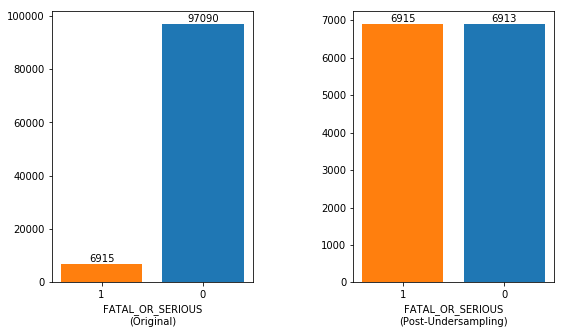

In [36]:
# Data for plotting
props_orig = crash_data.groupBy("FATAL_OR_SERIOUS").count().toPandas()
props_post_us = undersampled_data.groupBy("FATAL_OR_SERIOUS").count().toPandas()

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols = 2, figsize=(9, 5))
plt.subplots_adjust(wspace = 0.5)

ypos = np.arange(len(props_orig["FATAL_OR_SERIOUS"]))
bar_colours = ["#ff7f0e", "#1f77b4"]

# Bar plot for original data set proportion
ax[0].bar(ypos, props_orig["count"], tick_label = props_orig["FATAL_OR_SERIOUS"], color = bar_colours)
ax[0].set(xlabel = "FATAL_OR_SERIOUS\n(Original)")
# Annotation config
for p in ax[0].patches:
    ax[0].text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize = 10,
        ha = "center",
        va = "bottom"
    )

# Bar plot for undersampled data set proportion
ax[1].bar(ypos, props_post_us["count"], tick_label = props_post_us["FATAL_OR_SERIOUS"], color = bar_colours)
ax[1].set(xlabel = "FATAL_OR_SERIOUS\n(Post-Undersampling)")
# Annotation config
for p in ax[1].patches:
    ax[1].text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize = 10,
        ha = "center",
        va = "bottom"
    )

plt.show()

### 4.3 Data Finalisation
We finalise our data set by performing the following steps:

1. Encode categorical input variables using *StringIndexer*
2. One-hot encode these encoded categorical input variables using *OneHotEncoder*
3. Combine one-hot encoded categorical input variables and non-categorical input variables into a single vector using *VectorAssembler*
4. Pipe these steps into Spark
5. Obtain final version of the data set by fitting and transforming the undersampled data set through the pipe

In [23]:
# Get list of categorical columns
cat_cols = [f.name for f in undersampled_data.schema.fields if f.dataType.simpleString() == "string"]

# Get list of non-categorical columns and remove our target variable from the list
noncat_cols = [f.name for f in undersampled_data.schema.fields if f.dataType.simpleString() != "string"]
noncat_cols.remove("FATAL_OR_SERIOUS")

# Build StringIndexer stages
strIdx = [StringIndexer(inputCol = c, outputCol = "STRIDX_" + c) for c in cat_cols]

# Build OneHotEncoder stages
oneHot = [OneHotEncoder(inputCol = "STRIDX_" + c, outputCol = "OH_" + c) for c in cat_cols]

# Build VectorEncoder stage
assembler = VectorAssembler(
    #inputCols = ["STRIDX_" + c for c in cat_cols] + noncat_cols,
    inputCols = ["OH_" + c for c in cat_cols] + noncat_cols,
    outputCol = "features"
)

# Combine all stages to build the pipeline model
pipe = Pipeline(stages = strIdx + oneHot + [assembler])

# Fit and transform our undersampled data - this is the final version of our data
final_data = pipe.fit(undersampled_data).transform(undersampled_data).select(["features", "FATAL_OR_SERIOUS"])

## MODELLING
Data set will be split into training set training set and test set before the models are built. Models will then be built and trained on the training set and their performance be evaluated on the test set. Since the test set has never been seen by the model, the resulting performance will be a good measure to see how good the model is when it encounters unseen data.

Data split will follow the 70:30 ratio; that is 70% for the training set and 30% for the test set. We know that model accuracy increases as the training data gets larger. On the other hand, we also know that we get better accuracy on our error estimate with larger test data. Since our data is finite, there is always a trade-off between better model vs better test accuracy and 70:30 split seems to be sufficiently balanced for general data mining use.

We will use accuracy, AUC and F1-score to evaluate the performance of the models.

Where:

- **Accuracy** – measures the proportion of predictions being correct
- **F1-score** – measures the harmonic mean between precision and sensitivity
- **ROC (Receiver Operating Characteristic) curve** – summarises the trade-off between sensitivity and specificity at different thresholds
- **AUC** – the area under ROC curve which represents the degree of separation between binary classes. This tells us how well the models are in distinguishing between classes

In [24]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed = 722)

In [25]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

# Initialise models
LR = LogisticRegression(featuresCol = "features", labelCol = "FATAL_OR_SERIOUS")
RF = RandomForestClassifier(featuresCol = "features", labelCol = "FATAL_OR_SERIOUS")
DT = DecisionTreeClassifier(featuresCol = "features", labelCol = "FATAL_OR_SERIOUS")
GBC = GBTClassifier(featuresCol = "features", labelCol = "FATAL_OR_SERIOUS")


# Train models
#LR_model = Pipeline(stages = [LR]).fit(train_data)
LR_model = LR.fit(train_data)
RF_model = RF.fit(train_data)
DT_model = DT.fit(train_data)
GBC_model = GBC.fit(train_data)

# Predictions
LR_pred = LR_model.transform(test_data)
RF_pred = RF_model.transform(test_data)
DT_pred = DT_model.transform(test_data)
GBC_pred = GBC_model.transform(test_data)

In [26]:
# Evaluations
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluators
binary_eval = BinaryClassificationEvaluator(labelCol = "FATAL_OR_SERIOUS")
multi_eval_f1 = MulticlassClassificationEvaluator(labelCol = "FATAL_OR_SERIOUS", metricName = "f1")
multi_eval_acc = MulticlassClassificationEvaluator(labelCol = "FATAL_OR_SERIOUS", metricName = "accuracy")

# Create pandas data frame to store the result of our model metrics
model_metrics = pd.DataFrame(columns = ["Model", "Accuracy", "AUC", "F1"])

# Logistic Regression
model_metrics = model_metrics.append(
    {
        "Model" : "Logistic Regression",
        "Code" : "LR",
        "Accuracy" : multi_eval_acc.evaluate(LR_pred),
        "AUC" : binary_eval.evaluate(LR_pred),
        "F1" : multi_eval_f1.evaluate(LR_pred)
    },
    ignore_index = True
)

# Random Forest
model_metrics = model_metrics.append(
    {
        "Model" : "Random Forest",
        "Code" : "RF", 
        "Accuracy" : multi_eval_acc.evaluate(RF_pred),
        "AUC" : binary_eval.evaluate(RF_pred),
        "F1" : multi_eval_f1.evaluate(RF_pred)
    },
    ignore_index = True
)

# Decision Tree
model_metrics = model_metrics.append(
    {
        "Model" : "Decision Tree",
        "Code" : "DT", 
        "Accuracy" : multi_eval_acc.evaluate(DT_pred),
        "AUC" : binary_eval.evaluate(DT_pred),
        "F1" : multi_eval_f1.evaluate(DT_pred)
    },
    ignore_index = True
)

# Binary evaluator for Gradient Boost Tree as it does not have rawPrediction column
binary_eval_gbc = BinaryClassificationEvaluator(labelCol = "FATAL_OR_SERIOUS", rawPredictionCol = 'prediction')

# Gradient Boost Tree
model_metrics = model_metrics.append(
    {
        "Model" : "Gradient Tree Boosting",
        "Code" : "GBC", 
        "Accuracy" : multi_eval_acc.evaluate(GBC_pred),
        "AUC" : binary_eval_gbc.evaluate(GBC_pred),
        "F1" : multi_eval_f1.evaluate(GBC_pred)
    },
    ignore_index = True
)

model_metrics

,Model,Accuracy,AUC,F1,Code
0,Logistic Regression,0.673570,0.729634,0.673332,LR
1,Random Forest,0.679241,0.721259,0.678327,RF
2,Decision Tree,0.688856,0.668398,0.688475,DT
3,Gradient Tree Boosting,0.692554,0.691310,0.692085,GBC


Helper functions to plot confusion matrix heatmap

In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Generates confusion matrix
def generate_cm(pred):
    cm_rdd = pred.select("prediction", "FATAL_OR_SERIOUS").rdd.map(
        lambda x: (float(x["prediction"]), float(x["FATAL_OR_SERIOUS"]))
    )
    # Get the values
    cm = MulticlassMetrics(cm_rdd).confusionMatrix().toArray()
    
    return cm   

# Plots confusion matrix heatmap
def plot_cm(cm, code, ax, fig):
    im = ax.matshow(cm, cmap = "Blues")
    
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(
        model_metrics[model_metrics["Code"] == code]["Model"].item()\
        if code in model_metrics["Code"].values\
        else code
    )
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["TRUE", "FALSE"])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["TRUE", "FALSE"])
    
    ax.tick_params(
        axis = "x",
        bottom = True, top = False,
        labelbottom = True, labeltop = False
    )
    ax.tick_params(
        axis = "y",
        rotation = 90
    )
    
    # Display the colour bar
    fig.colorbar(im, ax = ax)
    
    # Get the range of the data
    cm_range = [cm.min(), cm.max()]
    # Calculate the threshold value for annotation text colour
    threshold = cm_range[0] + ((cm_range[1] - cm_range[0]) / 2)
    
    # Display annotation text
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "g"),
                horizontalalignment = "center",
                color = "white" if cm[i, j] > threshold else "black"
            ) 

Confusion matrices for each model

In [28]:
LR_cm = generate_cm(LR_pred)
RF_cm = generate_cm(RF_pred)
DT_cm = generate_cm(DT_pred)
GBC_cm = generate_cm(GBC_pred)

Plot confusion matrix heatmaps

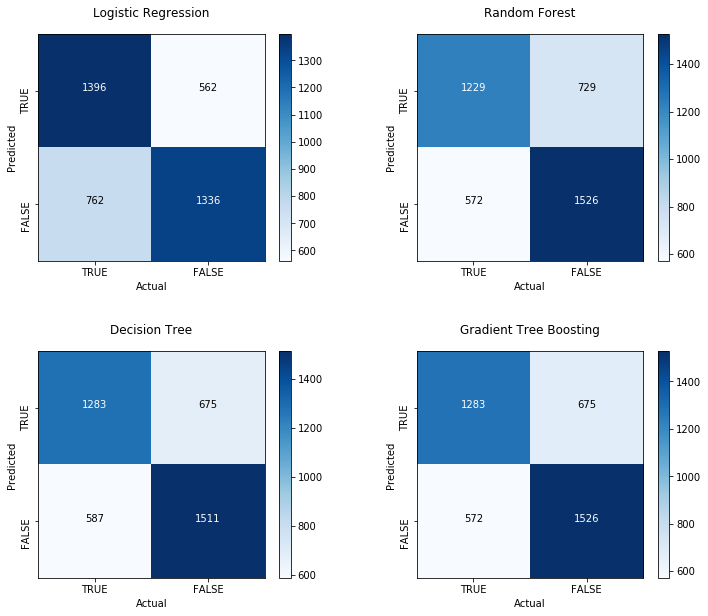

In [29]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)

plot_cm(LR_cm, "LR", ax[0, 0], fig)
plot_cm(RF_cm, "RF", ax[0, 1], fig)
plot_cm(DT_cm, "DT", ax[1, 0], fig)
plot_cm(GBC_cm, "GBC", ax[1, 1], fig)

plt.show()

Helper functions to plot ROC curve

In [30]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def get_roc_metrics(pred, code):
    if code == "GBC":
        bcm = BinaryClassificationMetrics(
            pred.select(["prediction", "FATAL_OR_SERIOUS"])\
            .rdd.map(lambda x: (float(x["prediction"]), float(x["FATAL_OR_SERIOUS"])))
        )
    else:
        bcm = BinaryClassificationMetrics(
            pred.select(["probability", "FATAL_OR_SERIOUS"])\
            .rdd.map(lambda x: (float(x["probability"][1]), float(x["FATAL_OR_SERIOUS"])))
        )
    # Use Scala version of BinaryClassificationMetrics as it implements .roc()
    rdd = getattr(bcm._java_model, "roc")().toJavaRDD()
    # Manually process the returned rdd as pySpark does not support Scala tuple
    pts = []
    for r in rdd.collect():
        pts += [(float(r._1()), float(r._2()))]
    
    return pts

def plot_roc_curve(pred, plt, code):
    roc = get_roc_metrics(pred, code)
    x_val = [x[0] for x in roc]
    y_val = [x[1] for x in roc]
    lbl = "{}, AUC={:.3f}".format(code, model_metrics[model_metrics["Code"] == code]["AUC"].item())
    plt.plot(x_val, y_val, label = lbl)

Plot ROC curve for each model.

Please note that Logistic Regression implementation in *pyspark.ml.classification* package does not provide prediction probabilities. So we used the prediction values instead. This resulted in a triangular shape plot as opposed to the smooth curve plot due the prediction value containing only 0 or 1.

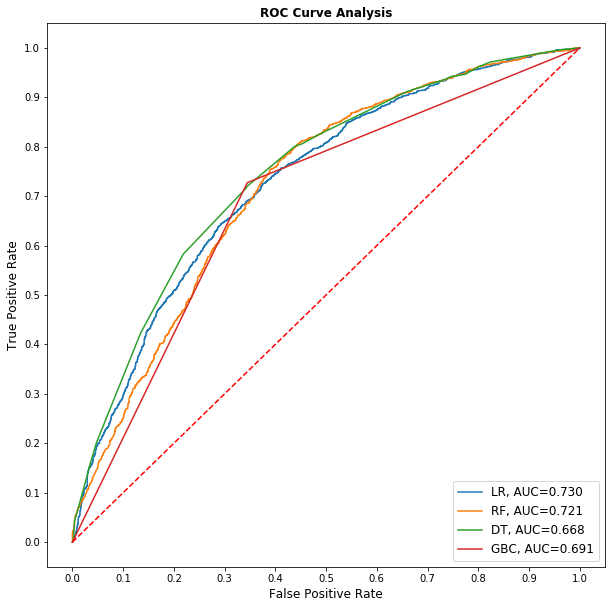

In [31]:
plt.figure(figsize = (10, 10))

# Plot ROC curves
plot_roc_curve(LR_pred, plt, "LR")
plot_roc_curve(RF_pred, plt, "RF")
plot_roc_curve(DT_pred, plt, "DT")
plot_roc_curve(GBC_pred, plt, "GBC")

# Diagonal red line indicating the prediction of random classifier (i.e. 50:50)
plt.plot([0,1], [0,1], color = "red", linestyle = "--")

# Plot config
plt.xticks(np.arange(0.0, 1.1, step = 0.1))
plt.xlabel("False Positive Rate", fontsize = 12)

plt.yticks(np.arange(0.0, 1.1, step = 0.1))
plt.ylabel("True Positive Rate", fontsize = 12)

plt.title("ROC Curve Analysis", fontweight = "bold", fontsize = 12)
plt.legend(prop = {"size" : 12}, loc = "lower right")

plt.show()

Feature importance metrics generated by the models

In [32]:
# Extract the list of features from the one-hot encoded vector
features = train_data\
    .schema["features"]\
    .metadata["ml_attr"]["attrs"]["binary"]\
    + train_data\
        .schema["features"]\
        .metadata["ml_attr"]["attrs"]["numeric"]

In [33]:
# Function to plot bar graph of feature importance metrics generated by the model
def plot_fi(model, code, ax):
    #Extract feature importance metrics from the model
    if code == "LR":
        importances = pd.DataFrame(
            [(f["name"], np.abs(model.coefficients[f["idx"]])) for f in features],
            columns = ["feature", "importance"]
        ).sort_values("importance", ascending = False)
    else:
        importances = pd.DataFrame(
            [(f["name"], model.featureImportances[f["idx"]]) for f in features],
            columns = ["feature", "importance"]
        ).sort_values("importance", ascending = False)
    
    importances["grouping"] = importances["feature"].apply(
        lambda x:
            "".join([f for f in (["OH_" + c for c in screen_cat_cols] + screen_noncat_cols) if x.startswith(f)])
        )
    
    summary = importances.groupby("grouping").mean().sort_values("importance", ascending = False)
    summary["feature"] = summary.index.tolist()
    
    # Plot bar graph
    ax.bar(
        np.arange(len(summary)),
        summary["importance"],
        tick_label = summary["feature"]
    )
    ax.set_title(
        model_metrics[model_metrics["Code"] == code]["Model"].item()\
        if code in model_metrics["Code"].values\
        else code
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)

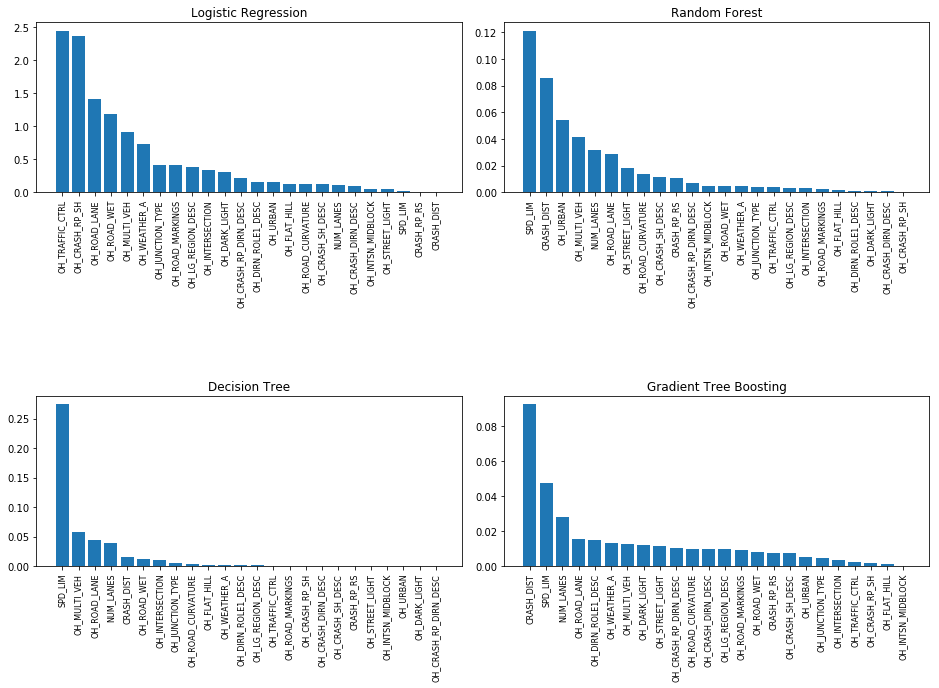

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0.1, hspace = 1.2)

plot_fi(LR_model, "LR", ax[0, 0])
plot_fi(RF_model, "RF", ax[0, 1])
plot_fi(DT_model, "DT", ax[1, 0])
plot_fi(GBC_model, "GBC", ax[1, 1])

## Elapsed Time

In [35]:
finish_time = datetime.datetime.now().replace(microsecond=0)

print(finish_time-start_time)

0:10:30
